## Prediction of future user adoption

## Introduction

The data is available as two attached CSV files: 'takehome_user_engagement.csv' and 'takehome_users.csv'.

### Objective

1.Define an "adopted user" as a user who has logged into the product on three separate days in at least
one seven day period.<br>
2.Identify which factors predict future user adoption.

In [34]:
# importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [2]:
#load data into dataframes
user_engagement=pd.read_csv('takehome_user_engagement.csv')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
#converting time_stamp to datetime
user_engagement['time_stamp']=pd.to_datetime(user_engagement['time_stamp'])

In [4]:
#load takehome-user data into dataframes
user=pd.read_csv("takehome_users.csv",encoding = "ISO-8859-1")
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
# obtaining ionformation about user
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
#converting time columns to datetime
user['creation_time']= pd.to_datetime(user.creation_time)
user['last_session_creation_time']=pd.to_datetime(user.last_session_creation_time)

## Determining adopted users

In [7]:
# determining the number of  visits by user in week
visits=user_engagement.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])[['visited']].count() 
visits=visits.reset_index()

In [8]:
#getting weekly count max per user
max_visits=visits.groupby('user_id')['visited'].max()
max_visits=max_visits.reset_index()

In [9]:
max_visits['adopted']=np.where(max_visits['visited']>=3,1,0)
max_visits.head()

,user_id,visited,adopted
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


## Data Wrangling

In [10]:
#merging two dataframes
user.rename({'object_id':'user_id'},inplace= True,axis=1)
df= pd.merge( user, max_visits, on='user_id', how ='outer')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  visited                     8823 non-null   float64       
 11  adopted                     8823 non-null   float64   

In [12]:
# filling the NaN values in the adopted column with zeros since those users did not log into the product at all
df['adopted'] = df['adopted'].fillna(0)
df['visited'] = df['visited'].fillna(0)
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(0)
df.tail()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1970-01-01 00:00:01.378448055,0,0,89,8263.0,1.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1970-01-01 00:00:01.358274517,0,0,200,NaN,1.0,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1970-01-01 00:00:01.398602716,1,1,83,8074.0,1.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1970-01-01 00:00:01.338638159,0,0,6,NaN,1.0,0.0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1970-01-01 00:00:01.390726632,0,1,0,NaN,1.0,0.0


## Feature Engineering

'creation_source' column consists of five categories. I am appying pd.get_dummies method to convert categorical variable into dummy/indicator variables. pd.get_dummies creates a new dataframe which consists of zeros and ones.

In [13]:
df.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [14]:
# making dummies variable to the creation.
data= pd.get_dummies(df,prefix=['cr_s'],columns=['creation_source'])
#creating a column showing if the user is invited by another user or not 
data['invited_by_user_id'] = np.where(df['invited_by_user_id'] > 0, 1, 0)

In [15]:
data.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,cr_s_GUEST_INVITE,cr_s_ORG_INVITE,cr_s_PERSONAL_PROJECTS,cr_s_SIGNUP,cr_s_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1970-01-01 00:00:01.398138810,1,0,11,1,1.0,0.0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1970-01-01 00:00:01.396237504,0,0,1,1,3.0,1.0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1970-01-01 00:00:01.363734892,0,0,94,1,1.0,0.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1970-01-01 00:00:01.369210168,0,0,1,1,1.0,0.0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1970-01-01 00:00:01.358849660,0,0,193,1,1.0,0.0,1,0,0,0,0


I used the 'time_stamp' column to find the months and days where each user logged into the product most. Then dividing this number by the total number of logins I obtained the percentages that shows the importance of that month.

In [16]:
from datetime import datetime as dt
user_engagement['month']= user_engagement['time_stamp'].dt.month
user_engagement['day']=user_engagement['time_stamp'].dt.day_name()
user_engagement.head()

,time_stamp,user_id,visited,month,day
0,2014-04-22 03:53:30,1,1,4,Tuesday
1,2013-11-15 03:45:04,2,1,11,Friday
2,2013-11-29 03:45:04,2,1,11,Friday
3,2013-12-09 03:45:04,2,1,12,Monday
4,2013-12-25 03:45:04,2,1,12,Wednesday


In [17]:
#showing the number of visits in the months that the user logged in
months_visits= user_engagement[['user_id','month','visited']]
months_visits=months_visits.groupby(['user_id','month']).sum()
months_visits=months_visits.reset_index()


In [18]:
months_visits.head()

,user_id,month,visited
0,1,4,1
1,2,1,1
2,2,2,5
3,2,3,3
4,2,11,2


In [19]:
# merging two dataframes
data = pd.merge(data, months_visits[['user_id','month']], on='user_id')

In [20]:
data.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,cr_s_GUEST_INVITE,cr_s_ORG_INVITE,cr_s_PERSONAL_PROJECTS,cr_s_SIGNUP,cr_s_SIGNUP_GOOGLE_AUTH,month
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1970-01-01 00:00:01.398138810,1,0,11,1,1.0,0.0,1,0,0,0,0,4
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1970-01-01 00:00:01.396237504,0,0,1,1,3.0,1.0,0,1,0,0,0,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1970-01-01 00:00:01.396237504,0,0,1,1,3.0,1.0,0,1,0,0,0,2
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1970-01-01 00:00:01.396237504,0,0,1,1,3.0,1.0,0,1,0,0,0,3
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1970-01-01 00:00:01.396237504,0,0,1,1,3.0,1.0,0,1,0,0,0,11


## Exploratory Data Analysis

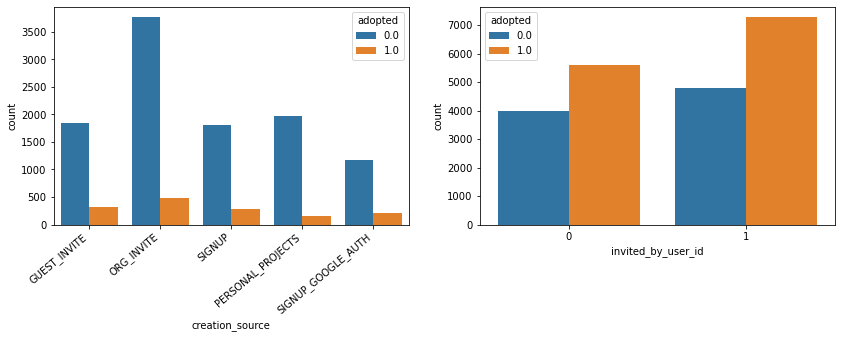

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))

# visualizing the categorical columns based on the adopted values
ax1 = sns.countplot(x='creation_source', data=df, hue='adopted', ax=axs[0])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax2= sns.countplot(x='invited_by_user_id', data=data, hue='adopted', ax=axs[1])


In the creation source variable, the organization invite feature has the most adopted users. It seems like, there is not a significant difference between the number of adopted users and non adopted users for the invited by user id feature, number of adopted users is only slightly higher for the invited users.

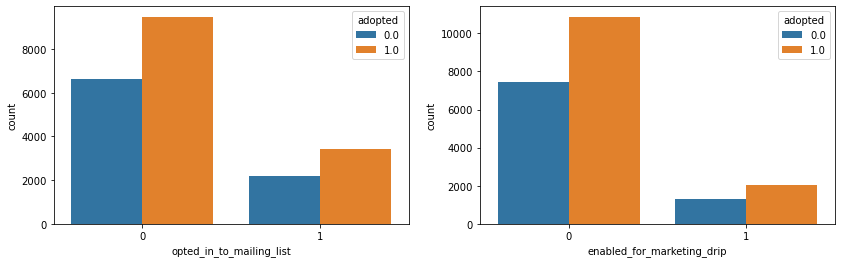

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))
ax3= sns.countplot(x='opted_in_to_mailing_list', data=data, hue='adopted', ax=axs[0])
ax4= sns.countplot(x='enabled_for_marketing_drip', data=data, hue='adopted', ax=axs[1])

For the opted in to mailing list variable, the number of adopted users are more than the number of non adopted users for the ones that are not in the mailing list. For the enabled for marketing drip variable, the number of adopted users are a lot more than the number of non adopted users for the ones that are not enabled for marketing drip variable. These two feature might contribute a potential value for the prediction algortihm.



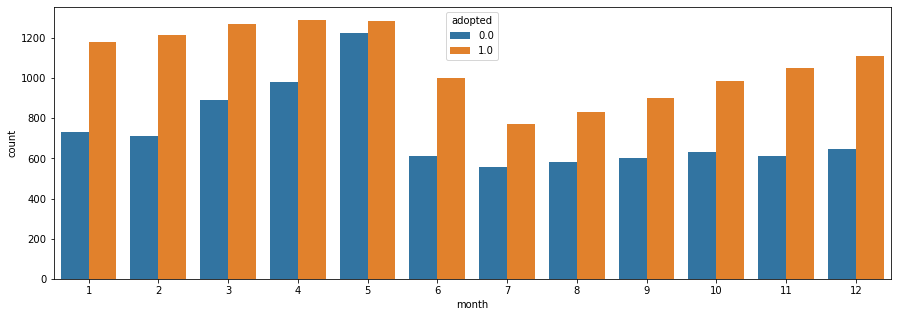

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(x='month', data = data, hue='adopted')
plt.show()

The above figure illustrates that the number of adopted users are increasing in spring months and reaching to max in May.

## Up-sample Minority Class

In [24]:
data.adopted.value_counts()

1.0    12890
0.0     8787
Name: adopted, dtype: int64

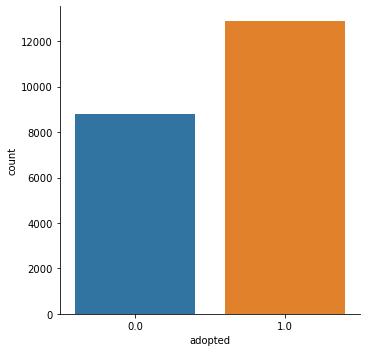

In [25]:
sns.catplot(x='adopted',kind='count',data=data)

The number of adopted non users is small compared to the number of adopted users. This might be a problem, because the classifier learns the classes with more samples better and remain weak on the smaller classes. So I increase the number of non adopted users with upsampling method. In upsampling, for every observation in the majority class, we randomly select an observation from the minority class with replacement. The end result is the same number of observations from the minority and majority classes.

In [26]:
data.columns

Index(['user_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'visited',
       'adopted', 'cr_s_GUEST_INVITE', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH',
       'month'],
      dtype='object')

In [31]:
df_final =data[['opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 
       'adopted', 'cr_s_GUEST_INVITE', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH',
       'month']]

# importing module for resampling
from sklearn.utils import resample

# seperate majority and minority class
df_final_majority=df_final[df_final.adopted == 1]
df_final_minority=df_final[df_final.adopted == 0]

# upsample minority class
df_final_minority_upsampled= resample(df_final_minority,
                                      replace=True,
                                      n_samples=len(df_final_majority),
                                      random_state=123)
# combine majority class with minority class
df_upsampled= pd.concat([df_final_majority,df_final_minority_upsampled])

#display counts
df_upsampled.adopted.value_counts()

0.0    12890
1.0    12890
Name: adopted, dtype: int64

## Model Prediction

Since we are trying to predict if a user is adopted or not, this is a binary classification problem. For this reason, I am going to use classification algorithms.

## Random Forest

In [32]:
#creating train_test_split
features= df_upsampled.drop('adopted',axis=1)
target= df_upsampled['adopted']

X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.3,random_state=42)


In [35]:
#Hyperparameter tuning by GridSearchcv

 
# Setup the parameters and distributions to sample from: param_grid

param_grid={"max_depth":[11,12,13],
           "max_features":[1,2,3,4],
           "min_samples_leaf":[0.1,1,2],
           "criterion":['gini','entropy']}
# instantiate the Gridsearchcv
grid_cv=GridSearchCV(RandomForestClassifier(),param_grid,cv=10)
#fit to training data
grid_cv.fit(X_train,y_train)

#print the tunned parameters and score

print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best CV score is {}".format(grid_cv.best_score_))




Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': 4, 'min_samples_leaf': 1}
Best CV score is 0.6907363138854254


In [36]:
#train and test classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print('Accuracy score on train set:', rf.score(X_train, y_train))
print('Accuracy score on test set:', rf.score(X_test, y_test))

Accuracy score on train set: 0.9270752521334368
Accuracy score on test set: 0.7019653478148435


In [38]:
# printing the classification report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71      3833
         1.0       0.73      0.65      0.69      3901

    accuracy                           0.70      7734
   macro avg       0.70      0.70      0.70      7734
weighted avg       0.70      0.70      0.70      7734



In [37]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=1)
xg.fit(X_train, y_train)

print('Accuracy score on train set:', xg.score(X_train, y_train))
print('Accuracy score on test set:', xg.score(X_test, y_test))

Accuracy score on train set: 0.8006760500942037
Accuracy score on test set: 0.7381691233514353


In [39]:
# printing the classification report
print(classification_report(y_test, xg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      3833
         1.0       0.73      0.76      0.74      3901

    accuracy                           0.74      7734
   macro avg       0.74      0.74      0.74      7734
weighted avg       0.74      0.74      0.74      7734



In [40]:
# Hyperparameter tunning

# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
import xgboost as xgb
param_grid_xgb= {"learning_rate": [ 0.5, 0.7, 1],
              "n_estimators": [100, 150, 200],
              "subsample": [0.5,0.9, 1]}
xgb_ = xgb.XGBClassifier(random_state=1)

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(estimator=xgb_, param_grid = param_grid_xgb, cv=4)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best CV score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'learning_rate': 0.7, 'n_estimators': 200, 'subsample': 1}
Best CV score is 0.7588392946281037


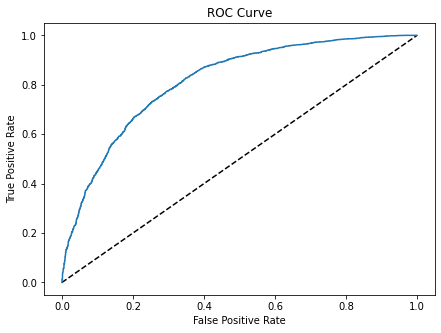

In [41]:
# Import necessary modules 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = xg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

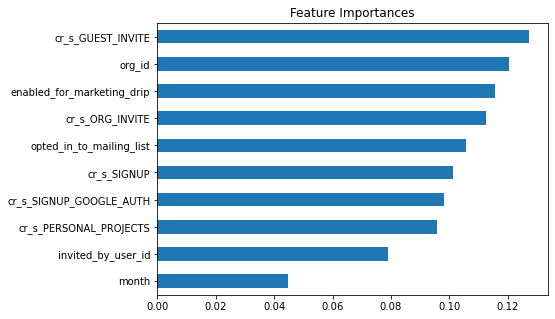

In [47]:
# Create series of the features importances and sort the values
importances = pd.Series(xg.feature_importances_, index=['opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 
        'cr_s_GUEST_INVITE', 'cr_s_ORG_INVITE',
       'cr_s_PERSONAL_PROJECTS', 'cr_s_SIGNUP', 'cr_s_SIGNUP_GOOGLE_AUTH',
       'month']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
plt.figure(figsize=(7,5))
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show();

In [46]:
xg.feature_importances_

array([0.10554327, 0.11550628, 0.12034718, 0.07881621, 0.12734292,
       0.11247227, 0.09577523, 0.1012149 , 0.09817729, 0.04480442],
      dtype=float32)

XGBOOST gives a higher score than Random Forest classifier. Most important features that predict future user adoption using the XGBoost is organization id, creation source and domain.RandomForestclassifier gives a lower accuracy. The most important features using this model are enable_for_marketing_drip ,creation source (guest invitation) and organization id.